### 1. Import neccessary packages

In [79]:
import numpy as np
import pandas as pd
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

### 2. Load data

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

Your submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict.

NOTE: We will need a dev set. Hence, we would get a subset from the training set.

In [80]:
train = pd.read_csv("datasets/mnist_train.csv")
test = pd.read_csv("datasets/mnist_test.csv")

In [81]:
test.columns

Index(['label', '1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7', '1x8', '1x9',
       ...
       '28x19', '28x20', '28x21', '28x22', '28x23', '28x24', '28x25', '28x26',
       '28x27', '28x28'],
      dtype='object', length=785)

### 3. separate train and test data into (x_train, y_train) and (x_test, y_test)

In [82]:
# Let's get the y_train and x_train set
Y_train_orig =  train["label"]

X_train_orig = train.drop(["label"], axis =1)

# Let's get the y_test and x_test set
Y_test_orig =  test["label"]

X_test_orig =  test.drop(["label"], axis =1)

print("X_train_orig shape = ", X_train_orig.shape)
print("Y_train_orig shape = ", Y_train_orig.shape)
print("X_test_orig shape = ", X_test_orig.shape)
print("Y_test_orig shape = ", Y_test_orig.shape)

X_train_orig shape =  (60000, 784)
Y_train_orig shape =  (60000,)
X_test_orig shape =  (10000, 784)
Y_test_orig shape =  (10000,)


In [83]:
X_train_orig[0:5]

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
Y_train_orig[0:5]

0    5
1    0
2    4
3    1
4    9
Name: label, dtype: int64

### 4. Normalize data

In [85]:
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.


Y_train = Y_train_orig
Y_test = Y_test_orig


### 5. Reshape data

For instance, this MINST data set contains 60,000 traning examples, 28 x28 x 1 pictures.

In [86]:
# Reshape image in 3 dimensions (height = 28 pixels, width = 28 pixels , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

### 6. Label encoding

In [87]:
from keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 10)
Y_test = to_categorical(Y_test,  num_classes = 10)


print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 60000
number of test examples = 10000
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)


### 7. Plot data

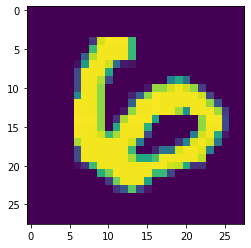

In [88]:
# Some examples
g = plt.imshow(X_train[9000][:,:,0])

### 8. Building a model in Keras

In [93]:
def MyMINST(input_shape, classes = 10):
    """
    Implementation of the digit recognizer model (MyMINST.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """

    #Returns:
   # model -- a Model() instance in Keras

    # Feel free to use the suggested outline in the text above to get started, and run through the whole
    # exercise (including the later portions of this notebook) once. The come back also try out other
    # network architectures as well. 
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (7, 7), strides = (1, 1), name = 'conv0',  kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc', kernel_initializer = glorot_uniform(seed=0))(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='MyMINST')

    
    ### END CODE HERE ###
    
    return model

In [94]:
model = MyMINST(input_shape = (28, 28, 1), classes = 10)

In [95]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [97]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 10000)

Epoch 1/2
60000/60000 [==============================] - 120s 2ms/step - loss: 0.3231 - accuracy: 0.9084
Epoch 2/2
60000/60000 [==============================] - 132s 2ms/step - loss: 0.2768 - accuracy: 0.9215


In [99]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10000/10000 [==============================] - 4s 440us/step
Loss = 1.5932726831436157
Test Accuracy = 0.9124000072479248


In [100]:
model.summary()

Model: "MyMINST"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 34, 34, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 64)        3200      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 28, 28, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 12544)             0   

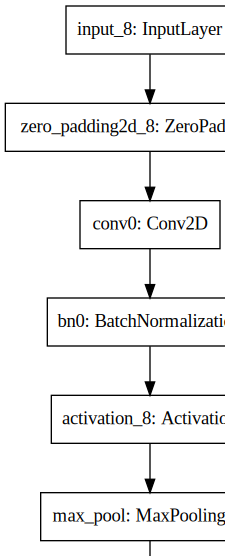

In [101]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))